In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas_datareader.data as web
import datetime
import backtrader as bt
%matplotlib inline
import pyfolio as pf
import quantstats
import sys
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import rankdata
from scipy.stats import stats
from scipy.optimize import minimize

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


Hierarchical Risk Parity를 구현해 보겠습니다. 대상은 미국 주식, 선진국 주식, 신흥국 주식, 미국 장기 국채, 미국 장기 TIPS, 미국 장기 회사채, 금, 원자재, 미국 섹터입니다. 중기 채권으로 하면 주식 쪽에 너무 비중이 작게 가는 문제가 있어 장기로 해 보겠습니다.

In [2]:
start = '2018-06-18'
end = '2021-05-21'

vti = web.DataReader("VTI", 'yahoo', start, end)['Adj Close'].to_frame("vti")
vea = web.DataReader("VEA", 'yahoo', start, end)['Adj Close'].to_frame("vea")
vwo = web.DataReader("VWO", 'yahoo', start, end)['Adj Close'].to_frame("vwo")
tlt = web.DataReader("TLT", 'yahoo', start, end)['Adj Close'].to_frame("tlt")
ltpz = web.DataReader("LTPZ", 'yahoo', start, end)['Adj Close'].to_frame("ltpz")
vclt = web.DataReader("VCLT", 'yahoo', start, end)['Adj Close'].to_frame("vclt")
iau = web.DataReader("IAU", 'yahoo', start, end)['Adj Close'].to_frame("iau")
dbc = web.DataReader("DBC", 'yahoo', start, end)['Adj Close'].to_frame("dbc")
xlb = web.DataReader("XLB", 'yahoo', start, end)['Adj Close'].to_frame("xlb")
xlc = web.DataReader("XLC", 'yahoo', start, end)['Adj Close'].to_frame("xlc")
xle = web.DataReader("XLE", 'yahoo', start, end)['Adj Close'].to_frame("xle")
xlf = web.DataReader("XLF", 'yahoo', start, end)['Adj Close'].to_frame("xlf")
xli = web.DataReader("XLI", 'yahoo', start, end)['Adj Close'].to_frame("xli")
xlk = web.DataReader("XLK", 'yahoo', start, end)['Adj Close'].to_frame("xlk")
xlp = web.DataReader("XLP", 'yahoo', start, end)['Adj Close'].to_frame("xlp")
xlu = web.DataReader("XLU", 'yahoo', start, end)['Adj Close'].to_frame("xlu")
xlv = web.DataReader("XLV", 'yahoo', start, end)['Adj Close'].to_frame("xlv")
xly = web.DataReader("XLY", 'yahoo', start, end)['Adj Close'].to_frame("xly")
xlre = web.DataReader("XLRE", 'yahoo', start, end)['Adj Close'].to_frame("xlre")

In [3]:
price_df = pd.concat([vti, vea, vwo, tlt, ltpz, vclt, iau, dbc, xlb, xlc, xle, xlf, xli, xlk, xlp, xlu, xlv, xly, xlre], axis=1)
return_df = price_df.pct_change().dropna(axis=0)

In [4]:
return_df

,vti,vea,vwo,tlt,ltpz,vclt,iau,dbc,xlb,xlc,xle,xlf,xli,xlk,xlp,xlu,xlv,xly,xlre
Date,,,,,,,,,,,,,,,,,,,
2018-06-20,0.002300,0.002061,0.003241,-0.008762,-0.009852,-0.007739,-0.004088,-0.001160,-0.003248,0.012410,0.004416,-0.002559,0.000683,0.002100,0.000979,0.000797,0.002121,0.004742,0.010794
2018-06-21,-0.006883,-0.006856,-0.014078,0.005254,0.005125,-0.001492,-0.002463,-0.007549,-0.010635,-0.006129,-0.018516,-0.002933,-0.012555,-0.007684,0.001957,0.003385,-0.005762,-0.007123,0.005967
2018-06-22,0.001427,0.010718,0.008128,-0.000083,0.003600,-0.000919,0.002469,0.019895,0.014563,0.004376,0.019951,-0.004779,0.003455,-0.003238,0.008201,0.006944,0.004495,-0.001704,0.008742
2018-06-25,-0.014040,-0.014062,-0.013087,0.002240,0.000149,-0.002184,-0.003284,-0.011475,-0.015550,-0.020598,-0.020093,-0.010713,-0.012671,-0.020763,0.005036,0.016552,-0.009184,-0.021739,-0.002476
2018-06-26,0.002278,0.001169,-0.004025,0.001407,0.003885,0.003687,-0.005766,0.009867,0.003819,0.001658,0.012629,-0.003361,0.003766,0.004038,-0.004240,0.001163,-0.003090,0.007163,0.005275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-17,-0.002134,-0.001553,0.000579,-0.002116,0.001444,-0.000979,0.012529,0.012493,0.008759,-0.007913,0.023182,0.001848,-0.003055,-0.007354,-0.001410,-0.008193,-0.001863,-0.001816,0.000477
2021-05-18,-0.007811,0.003500,0.014470,-0.002559,-0.004086,-0.005685,0.001125,-0.004828,-0.011051,-0.010199,-0.023205,-0.013966,-0.014558,-0.008001,-0.003107,-0.000153,0.000325,-0.007804,0.001906
2021-05-19,-0.002905,-0.008913,-0.002663,-0.002419,-0.012066,-0.002267,0.001124,-0.020485,-0.015279,0.001585,-0.024878,-0.006146,-0.005637,0.003510,-0.003258,-0.001683,-0.001704,-0.008397,-0.003805


In [5]:
# correlation matrix
corr = return_df.corr()

In [6]:
# distance matrix
d_corr = np.sqrt(0.5*(1-corr))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


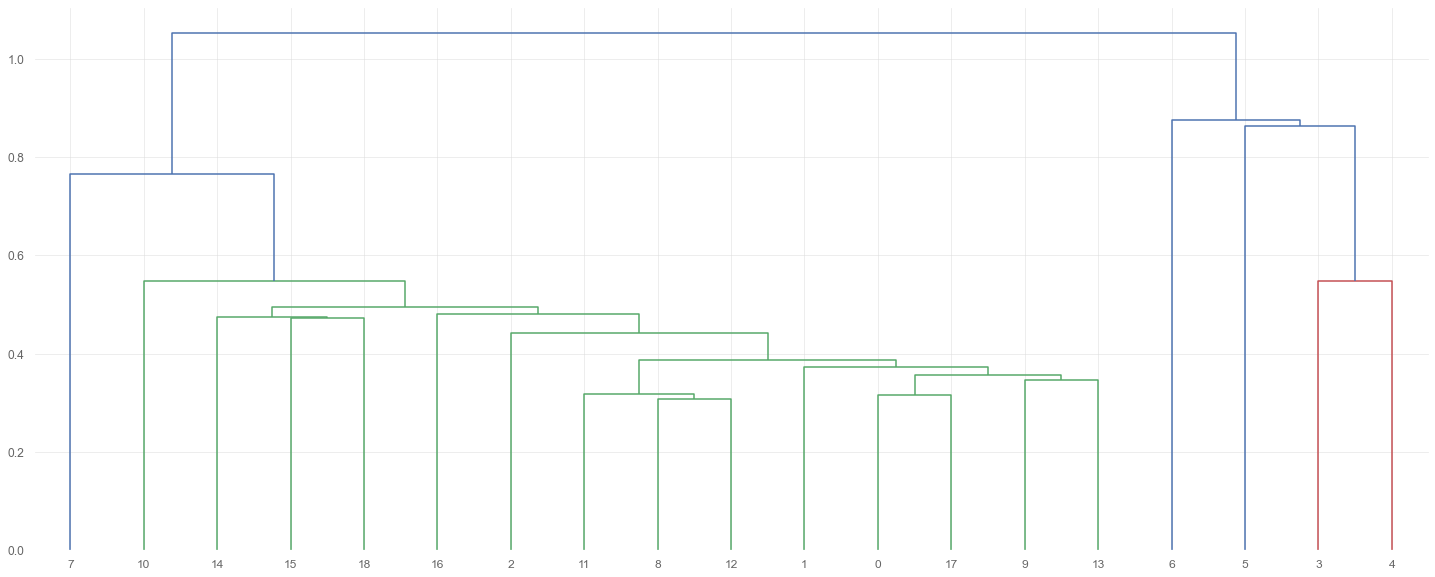

In [7]:
link = linkage(d_corr, 'single')
Z = pd.DataFrame(link)

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)
# plt.show()

위는 clustering을 한 뒤의 그림이고, 아래의 Z는 cluster 번호 2개, cluster끼리의 거리, cluster 안에 포함된 원소 개수를 나타냅니다. Hierarchical Clustering이 되었으니 Quasi-Diagonalization을 해 보겠습니다. Quasi Diagonalization은 covariance matrix에서 큰 값들을 diagonal로 보냅니다. 유사한 자산군을 붙여놓고 다른 자산군을 떨어뜨려 놓습니다. 

In [8]:
Z

,0,1,2,3
0,8.0,12.0,0.308292,2.0
1,0.0,17.0,0.315043,2.0
2,11.0,19.0,0.318654,3.0
3,9.0,13.0,0.346881,2.0
4,20.0,22.0,0.356569,4.0
5,1.0,23.0,0.373140,5.0
6,21.0,24.0,0.386952,8.0
7,2.0,25.0,0.442520,9.0
8,15.0,18.0,0.472410,2.0
9,14.0,27.0,0.475503,3.0


In [9]:
def get_quasi_diag(link):
    
    # sort clustered items by distance
    
    link = link.astype(int)
    
    # get the first and the second item of the last tuple
    sort_ix = pd.Series([link[-1,0], link[-1,1]]) 
    
    # the total num of items is the third item of the last list
    num_items = link[-1,3]
    
    # if the max of sort_ix is bigger than or equal to the max_items
    while sort_ix.max() >= num_items:

        sort_ix.index = range(0, sort_ix.shape[0]*2, 2) # make space
        
        df0 = sort_ix[sort_ix >= num_items] # find clusters
        
        # df0 contains even index and cluster index
        i = df0.index
        j = df0.values - num_items 
        
        sort_ix[i] = link[j,0] # item 1
        
        df0  = pd.Series(link[j, 1], index=i+1)
        
        sort_ix = sort_ix.append(df0) # item 2
        sort_ix = sort_ix.sort_index()
        
        sort_ix.index = range(sort_ix.shape[0])
    
    return sort_ix.tolist()

In [10]:
sort_ix = get_quasi_diag(link)
sort_ix

[7, 10, 14, 15, 18, 16, 2, 11, 8, 12, 1, 0, 17, 9, 13, 6, 5, 3, 4]

In [11]:
def get_cluster_var(cov, c_items):
    cov_ = cov.iloc[c_items, c_items] # matrix slice
    # calculate the inverse-variance portfolio
    ivp = 1./np.diag(cov_)
    ivp/=ivp.sum()
    w_ = ivp.reshape(-1,1)
    c_var = np.dot(np.dot(w_.T, cov_), w_)[0,0]
    return c_var

def get_rec_bipart(cov, sort_ix):
    # compute HRP allocation
    # intialize weights of 1
    w = pd.Series(1, index=sort_ix)
    
    # intialize all items in one cluster
    c_items = [sort_ix]
    while len(c_items) > 0:
        # bisection
        c_items = [i[int(j):int(k)] for i in c_items for j,k in 
                   ((0,len(i)/2),(len(i)/2,len(i))) if len(i)>1]
        
        # parse in pairs
        for i in range(0, len(c_items), 2):
            
            c_items0 = c_items[i] # cluster 1
            c_items1 = c_items[i+1] # cluter 2
            
            c_var0 = get_cluster_var(cov, c_items0)
            c_var1 = get_cluster_var(cov, c_items1)
            
            alpha = 1 - c_var0/(c_var0+c_var1)
            
            w[c_items0] *= alpha
            w[c_items1] *=1-alpha
            
    return w

In [12]:
cov = return_df.cov()
weights = get_rec_bipart(cov, sort_ix)

In [13]:
new_index = [return_df.columns[i] for i in weights.index]
weights.index = new_index

In [14]:
weights

dbc     0.069414
xle     0.014006
xlp     0.052168
xlu     0.029592
xlre    0.021390
xlv     0.032335
vwo     0.024277
xlf     0.008209
xlb     0.010514
xli     0.029322
vea     0.047293
vti     0.037005
xly     0.018139
xlc     0.017726
xlk     0.060270
iau     0.232143
vclt    0.143141
tlt     0.079744
ltpz    0.073310
dtype: float64

In [33]:
weights[0:19]

dbc     0.069414
xle     0.014006
xlp     0.052168
xlu     0.029592
xlre    0.021390
xlv     0.032335
vwo     0.024277
xlf     0.008209
xlb     0.010514
xli     0.029322
vea     0.047293
vti     0.037005
xly     0.018139
xlc     0.017726
xlk     0.060270
iau     0.232143
vclt    0.143141
tlt     0.079744
ltpz    0.073310
dtype: float64

<BarContainer object of 19 artists>

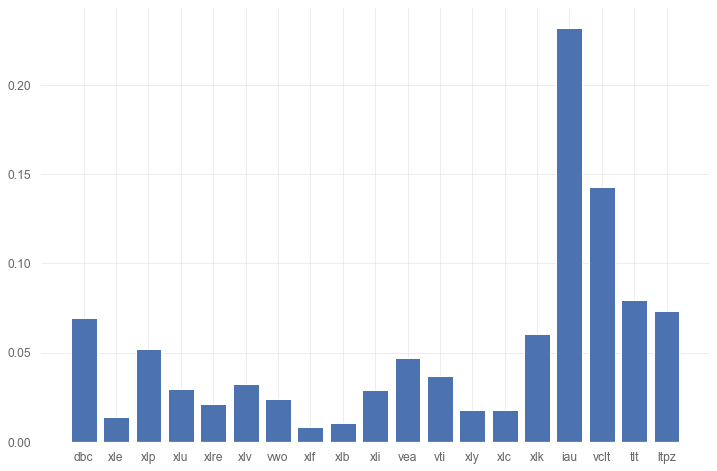

In [36]:
plt.figure(figsize = (12, 8))
plt.bar(list(weights.index), weights)